In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:15 - loss: 0.0771 - STD: 8.8847e-05 - MAE: 0.2611

 4/64 [>.............................] - ETA: 1s - loss: 0.0301 - STD: 2.5791e-04 - MAE: 0.1345  

 5/64 [=>............................] - ETA: 2s - loss: 0.0286 - STD: 2.3372e-04 - MAE: 0.1309

 6/64 [=>............................] - ETA: 2s - loss: 0.0280 - STD: 2.1042e-04 - MAE: 0.1297

 7/64 [==>...........................] - ETA: 2s - loss: 0.0276 - STD: 1.9021e-04 - MAE: 0.1293

 8/64 [==>...........................] - ETA: 2s - loss: 0.0273 - STD: 1.7288e-04 - MAE: 0.1288

 9/64 [===>..........................] - ETA: 2s - loss: 0.0270 - STD: 1.5825e-04 - MAE: 0.1282

10/64 [===>..........................] - ETA: 2s - loss: 0.0266 - STD: 1.4590e-04 - MAE: 0.1272

11/64 [====>.........................] - ETA: 2s - loss: 0.0262 - STD: 1.3560e-04 - MAE: 0.1260

12/64 [====>.........................] - ETA: 2s - loss: 0.0256 - STD: 1.2715e-04 - MAE: 0.1242

13/64 [=====>........................] - ETA: 2s - loss: 0.0249 - STD: 1.2038e-04 - MAE: 0.1219

14/64 [=====>........................] - ETA: 2s - loss: 0.0242 - STD: 1.1499e-04 - MAE: 0.1195

15/64 [======>.......................] - ETA: 2s - loss: 0.0234 - STD: 1.1084e-04 - MAE: 0.1169

16/64 [======>.......................] - ETA: 2s - loss: 0.0226 - STD: 1.0764e-04 - MAE: 0.1142

17/64 [======>.......................] - ETA: 2s - loss: 0.0219 - STD: 1.0517e-04 - MAE: 0.1121

18/64 [=======>......................] - ETA: 2s - loss: 0.0212 - STD: 1.0318e-04 - MAE: 0.1103

19/64 [=======>......................] - ETA: 2s - loss: 0.0206 - STD: 1.0158e-04 - MAE: 0.1090

20/64 [========>.....................] - ETA: 2s - loss: 0.0202 - STD: 1.0022e-04 - MAE: 0.1083

21/64 [========>.....................] - ETA: 2s - loss: 0.0199 - STD: 9.8969e-05 - MAE: 0.1077

22/64 [=========>....................] - ETA: 2s - loss: 0.0196 - STD: 9.7941e-05 - MAE: 0.1073

23/64 [=========>....................] - ETA: 2s - loss: 0.0193 - STD: 9.6878e-05 - MAE: 0.1068

24/64 [==========>...................] - ETA: 2s - loss: 0.0189 - STD: 9.5934e-05 - MAE: 0.1061

25/64 [==========>...................] - ETA: 2s - loss: 0.0186 - STD: 9.5009e-05 - MAE: 0.1054

26/64 [===========>..................] - ETA: 2s - loss: 0.0183 - STD: 9.4149e-05 - MAE: 0.1045

27/64 [===========>..................] - ETA: 2s - loss: 0.0180 - STD: 9.3371e-05 - MAE: 0.1036

28/64 [============>.................] - ETA: 1s - loss: 0.0177 - STD: 9.2609e-05 - MAE: 0.1026

29/64 [============>.................] - ETA: 1s - loss: 0.0174 - STD: 9.1814e-05 - MAE: 0.1017

30/64 [=============>................] - ETA: 2s - loss: 0.0174 - STD: 9.1046e-05 - MAE: 0.1009

34/64 [==============>...............] - ETA: 1s - loss: 0.0166 - STD: 8.8694e-05 - MAE: 0.0980

35/64 [===============>..............] - ETA: 1s - loss: 0.0164 - STD: 8.8310e-05 - MAE: 0.0974

36/64 [===============>..............] - ETA: 1s - loss: 0.0163 - STD: 8.8051e-05 - MAE: 0.0968

37/64 [================>.............] - ETA: 1s - loss: 0.0161 - STD: 8.7885e-05 - MAE: 0.0963

38/64 [================>.............] - ETA: 1s - loss: 0.0160 - STD: 8.7808e-05 - MAE: 0.0957

39/64 [=================>............] - ETA: 1s - loss: 0.0158 - STD: 8.7848e-05 - MAE: 0.0952

40/64 [=================>............] - ETA: 1s - loss: 0.0156 - STD: 8.7981e-05 - MAE: 0.0948

41/64 [==================>...........] - ETA: 1s - loss: 0.0155 - STD: 8.8172e-05 - MAE: 0.0944

42/64 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 8.8443e-05 - MAE: 0.0941

43/64 [===================>..........] - ETA: 1s - loss: 0.0152 - STD: 8.8785e-05 - MAE: 0.0937

44/64 [===================>..........] - ETA: 1s - loss: 0.0151 - STD: 8.9218e-05 - MAE: 0.0935

45/64 [====================>.........] - ETA: 1s - loss: 0.0150 - STD: 8.9667e-05 - MAE: 0.0932

46/64 [====================>.........] - ETA: 1s - loss: 0.0149 - STD: 9.0165e-05 - MAE: 0.0930

47/64 [=====================>........] - ETA: 1s - loss: 0.0148 - STD: 9.0603e-05 - MAE: 0.0927

48/64 [=====================>........] - ETA: 0s - loss: 0.0147 - STD: 9.1097e-05 - MAE: 0.0925

49/64 [=====================>........] - ETA: 0s - loss: 0.0146 - STD: 9.1607e-05 - MAE: 0.0922

50/64 [======================>.......] - ETA: 0s - loss: 0.0145 - STD: 9.2109e-05 - MAE: 0.0919

51/64 [======================>.......] - ETA: 0s - loss: 0.0144 - STD: 9.2676e-05 - MAE: 0.0916

52/64 [=======================>......] - ETA: 0s - loss: 0.0143 - STD: 9.3262e-05 - MAE: 0.0914

53/64 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 9.3842e-05 - MAE: 0.0911

54/64 [========================>.....] - ETA: 0s - loss: 0.0142 - STD: 9.4444e-05 - MAE: 0.0908

55/64 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 9.5057e-05 - MAE: 0.0906

56/64 [=========================>....] - ETA: 0s - loss: 0.0140 - STD: 9.5711e-05 - MAE: 0.0903

57/64 [=========================>....] - ETA: 0s - loss: 0.0139 - STD: 9.6422e-05 - MAE: 0.0901

58/64 [==========================>...] - ETA: 0s - loss: 0.0139 - STD: 9.7170e-05 - MAE: 0.0898

59/64 [==========================>...] - ETA: 0s - loss: 0.0138 - STD: 9.7965e-05 - MAE: 0.0896

60/64 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 9.8827e-05 - MAE: 0.0894

61/64 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 9.9698e-05 - MAE: 0.0892

62/64 [============================>.] - ETA: 0s - loss: 0.0136 - STD: 1.0064e-04 - MAE: 0.0890

63/64 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 1.0163e-04 - MAE: 0.0889

64/64 [==============================] - ETA: 0s - loss: 0.0135 - STD: 1.0266e-04 - MAE: 0.0887

64/64 [==============================] - 6s 71ms/step - loss: 0.0135 - STD: 1.0266e-04 - MAE: 0.0887 - val_loss: 0.0094 - val_STD: 1.2339e-04 - val_MAE: 0.0773


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 1.7098e-04 - MAE: 0.0785

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 1.7289e-04 - MAE: 0.0784

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 1.7543e-04 - MAE: 0.0785

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.7786e-04 - MAE: 0.0785

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.8012e-04 - MAE: 0.0786

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.8246e-04 - MAE: 0.0785

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8439e-04 - MAE: 0.0784

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8653e-04 - MAE: 0.0783

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8869e-04 - MAE: 0.0782

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.9080e-04 - MAE: 0.0781

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.9294e-04 - MAE: 0.0781

12/64 [====>.........................] - ETA: 2s - loss: 0.0099 - STD: 1.9510e-04 - MAE: 0.0780

13/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.9753e-04 - MAE: 0.0779

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 2.0000e-04 - MAE: 0.0779

15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.0260e-04 - MAE: 0.0779

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.0523e-04 - MAE: 0.0778

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.0800e-04 - MAE: 0.0778

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.1078e-04 - MAE: 0.0778

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.1369e-04 - MAE: 0.0778

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.1680e-04 - MAE: 0.0778

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.1992e-04 - MAE: 0.0778

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.2299e-04 - MAE: 0.0778

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.2623e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.2964e-04 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.3293e-04 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.3630e-04 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.3975e-04 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.4337e-04 - MAE: 0.0778

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 2.4703e-04 - MAE: 0.0778

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.5082e-04 - MAE: 0.0779

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.5483e-04 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.5887e-04 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.6292e-04 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.6712e-04 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.7149e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.7592e-04 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.8049e-04 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.8522e-04 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.9492e-04 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.9981e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.0506e-04 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1044e-04 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1599e-04 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.2157e-04 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.2756e-04 - MAE: 0.0778

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.3365e-04 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.3989e-04 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.4642e-04 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.5313e-04 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.6008e-04 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.6712e-04 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.7455e-04 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.8216e-04 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.9001e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.9807e-04 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.0646e-04 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.1502e-04 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.2396e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.3318e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.4284e-04 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.5284e-04 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.6324e-04 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 4.7392e-04 - MAE: 0.0778

64/64 [==============================] - 4s 59ms/step - loss: 0.0099 - STD: 4.7392e-04 - MAE: 0.0778 - val_loss: 0.0093 - val_STD: 8.6316e-04 - val_MAE: 0.0761


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0096 - STD: 0.0012 - MAE: 0.0771

 2/64 [..............................] - ETA: 3s - loss: 0.0096 - STD: 0.0012 - MAE: 0.0765

 3/64 [>.............................] - ETA: 3s - loss: 0.0096 - STD: 0.0013 - MAE: 0.0766

 4/64 [>.............................] - ETA: 3s - loss: 0.0096 - STD: 0.0013 - MAE: 0.0767

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0013 - MAE: 0.0770

 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0013 - MAE: 0.0770

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0773

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0773

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0775

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0775

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0775

13/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0776

14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0776

15/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0776

16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0776

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0775

18/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0775

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0775

20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0019 - MAE: 0.0774

21/64 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

22/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

23/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0773

24/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

25/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0773

26/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

27/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0772

28/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0772

29/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0772

30/64 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771

31/64 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0771

32/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0770

33/64 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0769

34/64 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0769

35/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0769

36/64 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0769

37/64 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0769

38/64 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0769

39/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0768

41/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0768

42/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0768

43/64 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0767

44/64 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0767

45/64 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.0048 - MAE: 0.0766

46/64 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0765

47/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0765

48/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0764

49/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0057 - MAE: 0.0764

50/64 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0060 - MAE: 0.0763

51/64 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0062 - MAE: 0.0762

52/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0065 - MAE: 0.0762

53/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0068 - MAE: 0.0761

54/64 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0071 - MAE: 0.0760

55/64 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0074 - MAE: 0.0759

56/64 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0077 - MAE: 0.0758

57/64 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0081 - MAE: 0.0757

58/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0084 - MAE: 0.0756

59/64 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0088 - MAE: 0.0756

60/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0091 - MAE: 0.0755

61/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0095 - MAE: 0.0754

62/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0099 - MAE: 0.0753

63/64 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0102 - MAE: 0.0752

64/64 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0106 - MAE: 0.0752

64/64 [==============================] - 4s 61ms/step - loss: 0.0092 - STD: 0.0106 - MAE: 0.0752 - val_loss: 0.0073 - val_STD: 0.0247 - val_MAE: 0.0678


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0078 - STD: 0.0358 - MAE: 0.0689

 2/64 [..............................] - ETA: 3s - loss: 0.0079 - STD: 0.0364 - MAE: 0.0693

 3/64 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.0368 - MAE: 0.0690

 4/64 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.0372 - MAE: 0.0690

 5/64 [=>............................] - ETA: 3s - loss: 0.0078 - STD: 0.0375 - MAE: 0.0687

 6/64 [=>............................] - ETA: 3s - loss: 0.0078 - STD: 0.0378 - MAE: 0.0686

 7/64 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0380 - MAE: 0.0684

 8/64 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0382 - MAE: 0.0683

 9/64 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.0384 - MAE: 0.0683

10/64 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.0386 - MAE: 0.0682

11/64 [====>.........................] - ETA: 3s - loss: 0.0077 - STD: 0.0387 - MAE: 0.0681

12/64 [====>.........................] - ETA: 2s - loss: 0.0077 - STD: 0.0389 - MAE: 0.0680

13/64 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.0390 - MAE: 0.0679

14/64 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.0392 - MAE: 0.0678

15/64 [======>.......................] - ETA: 2s - loss: 0.0076 - STD: 0.0394 - MAE: 0.0678

16/64 [======>.......................] - ETA: 2s - loss: 0.0076 - STD: 0.0396 - MAE: 0.0677

17/64 [======>.......................] - ETA: 2s - loss: 0.0076 - STD: 0.0398 - MAE: 0.0677

18/64 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.0401 - MAE: 0.0676

19/64 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.0403 - MAE: 0.0675

20/64 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.0406 - MAE: 0.0675

21/64 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.0408 - MAE: 0.0674

22/64 [=========>....................] - ETA: 2s - loss: 0.0076 - STD: 0.0410 - MAE: 0.0673

23/64 [=========>....................] - ETA: 2s - loss: 0.0075 - STD: 0.0413 - MAE: 0.0672

24/64 [==========>...................] - ETA: 2s - loss: 0.0075 - STD: 0.0415 - MAE: 0.0671

25/64 [==========>...................] - ETA: 2s - loss: 0.0075 - STD: 0.0417 - MAE: 0.0671

26/64 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0420 - MAE: 0.0670

27/64 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0422 - MAE: 0.0668

28/64 [============>.................] - ETA: 2s - loss: 0.0075 - STD: 0.0424 - MAE: 0.0667

29/64 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.0426 - MAE: 0.0667

31/64 [=============>................] - ETA: 1s - loss: 0.0074 - STD: 0.0430 - MAE: 0.0664

32/64 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0432 - MAE: 0.0663

33/64 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0434 - MAE: 0.0662

34/64 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0436 - MAE: 0.0661

35/64 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.0438 - MAE: 0.0660

36/64 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.0440 - MAE: 0.0659

37/64 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0442 - MAE: 0.0658

38/64 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.0444 - MAE: 0.0657

39/64 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0446 - MAE: 0.0656

40/64 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0449 - MAE: 0.0655

41/64 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0451 - MAE: 0.0654

42/64 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0453 - MAE: 0.0653

43/64 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0455 - MAE: 0.0652

44/64 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0458 - MAE: 0.0651

45/64 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0459 - MAE: 0.0649

46/64 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0461 - MAE: 0.0648

47/64 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0464 - MAE: 0.0647

48/64 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0466 - MAE: 0.0646

49/64 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0468 - MAE: 0.0645

50/64 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0470 - MAE: 0.0644

51/64 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0472 - MAE: 0.0643

52/64 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0474 - MAE: 0.0642

53/64 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0476 - MAE: 0.0641

54/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0478 - MAE: 0.0639

55/64 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0480 - MAE: 0.0638

56/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0482 - MAE: 0.0637

57/64 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0484 - MAE: 0.0636

58/64 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0486 - MAE: 0.0635

59/64 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0488 - MAE: 0.0634

60/64 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0489 - MAE: 0.0633

61/64 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0491 - MAE: 0.0632

62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0493 - MAE: 0.0631

63/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0495 - MAE: 0.0630

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0497 - MAE: 0.0629

64/64 [==============================] - 4s 60ms/step - loss: 0.0067 - STD: 0.0497 - MAE: 0.0629 - val_loss: 0.0049 - val_STD: 0.0552 - val_MAE: 0.0543


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0616 - MAE: 0.0578

 2/64 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0581

 3/64 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0578

 4/64 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0579

 5/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0575

 6/64 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0573

 7/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0574

 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0631 - MAE: 0.0573

 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0574

10/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0573

11/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0633 - MAE: 0.0572

12/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0572

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0571

14/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0632 - MAE: 0.0571

15/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0632 - MAE: 0.0570

16/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0630 - MAE: 0.0570

17/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0630 - MAE: 0.0570

18/64 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0569

19/64 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0569

20/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0570

21/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0570

22/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0569

23/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0570

24/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0569

25/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0569

26/64 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0569

27/64 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0569

28/64 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0568

29/64 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0569

30/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0568

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0568

32/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0631 - MAE: 0.0569

33/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0631 - MAE: 0.0569

34/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0631 - MAE: 0.0568

35/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0569

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0568

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0568

39/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0567

40/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0631 - MAE: 0.0567

41/64 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0568

42/64 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0568

43/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0567

44/64 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0567

45/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0567

46/64 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0567

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0567

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0567

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0567

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0567

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0567

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0567

53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0566

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0635 - MAE: 0.0566

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0566

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0565

63/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0565

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0565

64/64 [==============================] - 4s 60ms/step - loss: 0.0056 - STD: 0.0636 - MAE: 0.0565 - val_loss: 0.0046 - val_STD: 0.0551 - val_MAE: 0.0519


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0558

 2/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0551

 3/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0561

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0558

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0643 - MAE: 0.0557

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0559

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0558

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0643 - MAE: 0.0557

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0557

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0558

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0557

12/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0556

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0557

14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0556

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0556

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0556

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0556

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0555

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0556

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0556

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0555

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0555

24/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0554

25/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0554

27/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

28/64 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

29/64 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0554

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0554

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0554

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0554

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

37/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

39/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

40/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0553

41/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0553

42/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0553

43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0553

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0552

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0552

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0552

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0552

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0552

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0552

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0552

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0551

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0552

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0551

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551

64/64 [==============================] - 4s 61ms/step - loss: 0.0053 - STD: 0.0657 - MAE: 0.0551 - val_loss: 0.0045 - val_STD: 0.0601 - val_MAE: 0.0523


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0555

 2/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

 3/64 [>.............................] - ETA: 3s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0546

 4/64 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

 5/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

 6/64 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0546

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

14/64 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0544

15/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0544

16/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0544

17/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0545

18/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0544

19/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0544

20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0545

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0544

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0545

23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0545

24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0544

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0545

30/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0544

33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0543

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0542

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0542

45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0542

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

47/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0542

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0543

64/64 [==============================] - 4s 60ms/step - loss: 0.0052 - STD: 0.0672 - MAE: 0.0543 - val_loss: 0.0047 - val_STD: 0.0627 - val_MAE: 0.0541


Epoch 8/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0572

 2/64 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0563

 3/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0676 - MAE: 0.0564

 5/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0562

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0556

 7/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0671 - MAE: 0.0568

 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0660 - MAE: 0.0566

 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0563

10/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0656 - MAE: 0.0566

12/64 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0564

13/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0561

14/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0564

15/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0562

16/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0561

17/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0560

18/64 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0561

19/64 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0560

20/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0559

21/64 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0558

22/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0559

23/64 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

24/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0557

25/64 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0556

26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0556

27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0555

28/64 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0654 - MAE: 0.0554

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0554

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0553

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0552

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0552

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0551

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0551

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0550

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0550

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0549

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0548

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0548

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0548

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0548

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0547

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0547

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0546

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0546

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0546

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0545

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0545

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0545

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0545

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0545

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0545

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0544

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0544

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0544

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0543

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0543

64/64 [==============================] - 4s 61ms/step - loss: 0.0052 - STD: 0.0671 - MAE: 0.0543 - val_loss: 0.0043 - val_STD: 0.0611 - val_MAE: 0.0507


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0533

 2/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0527

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529

 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0532

 5/64 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0530

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0529

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0530

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0530

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0530

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

15/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0531

16/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0530

17/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0530

18/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0531

19/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0532

23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0532

24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0531

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0532

26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0531

27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0532

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0531

30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0531

32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

40/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

41/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

47/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

48/64 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0531

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0531

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0530

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

64/64 [==============================] - 4s 64ms/step - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530 - val_loss: 0.0044 - val_STD: 0.0647 - val_MAE: 0.0513


Epoch 10/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0729 - MAE: 0.0540

 3/64 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0532

 4/64 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0531

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0530

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0531

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0529

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0528

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0528

11/64 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0528

12/64 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0529

13/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0528

14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0527

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0526

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0526

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0525

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0525

31/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0525

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0526

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0525

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0525

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0525

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0525

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0526

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0525

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0525

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0526

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0526

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0527

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0527

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526

64/64 [==============================] - 4s 66ms/step - loss: 0.0049 - STD: 0.0696 - MAE: 0.0526 - val_loss: 0.0042 - val_STD: 0.0624 - val_MAE: 0.0501


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0516

 2/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0526

 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0521

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0522

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0522

 7/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0521

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0522

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0521

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0520

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0520

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0520

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0519

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0519

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0519

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0519

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0520

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0520

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0520

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0520

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0520

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0518

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0518

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0518

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0518

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0518

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0518

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0519

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519

64/64 [==============================] - 4s 67ms/step - loss: 0.0048 - STD: 0.0707 - MAE: 0.0519 - val_loss: 0.0042 - val_STD: 0.0600 - val_MAE: 0.0489


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0506

 2/64 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0517

 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0517

 4/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0520

 5/64 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0517

 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0517

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0514

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0514

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

13/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0515

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0516

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0516

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0516

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0517

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0517

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0517

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0516

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0515

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0516

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0516

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0516

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0516

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0515

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0516

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0516

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0515

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515

64/64 [==============================] - 4s 68ms/step - loss: 0.0047 - STD: 0.0709 - MAE: 0.0515 - val_loss: 0.0042 - val_STD: 0.0644 - val_MAE: 0.0497


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0511

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0507

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0505

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0507

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0506

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0506

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0505

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

19/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0507

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0508

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0511

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0510

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0514

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0515

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0515

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0516

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0516

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0516

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0517

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0517

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0517

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0518

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0518

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0517

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0709 - MAE: 0.0518

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0707 - MAE: 0.0518

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0518

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0520

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0520

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0522

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0522

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0524

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0524

48/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0524

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0524

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0525

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0524

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0524

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0523

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0523

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0523

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

64/64 [==============================] - 4s 69ms/step - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523 - val_loss: 0.0040 - val_STD: 0.0623 - val_MAE: 0.0486


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0512

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0509

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0508

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0514

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0511

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0510

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0510

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0509

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0510

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0510

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

18/64 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0508

22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0507

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0504

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

64/64 [==============================] - 4s 68ms/step - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504 - val_loss: 0.0041 - val_STD: 0.0608 - val_MAE: 0.0480


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0493

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0500

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0501

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0502

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0502

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0502

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0502

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0502

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0501

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0501

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0502

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0502

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0502

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0502

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0503

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0503

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0504

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0504

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0504

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0504

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0504

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0724 - MAE: 0.0503

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0503

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0503

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0503

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0503

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0503

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0503

64/64 [==============================] - 4s 69ms/step - loss: 0.0045 - STD: 0.0726 - MAE: 0.0503 - val_loss: 0.0040 - val_STD: 0.0636 - val_MAE: 0.0478


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0496

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0495

 3/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0506

 4/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0505

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0506

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0504

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0503

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0501

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0502

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0501

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0501

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0502

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0502

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0502

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0502

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0503

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0503

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0504

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0510

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0517

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0517

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0524

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0524

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0525

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0525

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0527

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0528

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0528

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0528

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0528

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0528

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0694 - MAE: 0.0528

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0528

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528

64/64 [==============================] - 4s 68ms/step - loss: 0.0050 - STD: 0.0691 - MAE: 0.0528 - val_loss: 0.0046 - val_STD: 0.0665 - val_MAE: 0.0544


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0573

 2/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0545

 3/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

 4/64 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0528

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0665 - MAE: 0.0529

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0535

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0532

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0666 - MAE: 0.0528

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0526

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0526

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0527

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0525

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0524

14/64 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0522

15/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0522

16/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0521

17/64 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0520

18/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0519

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0519

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0518

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0517

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0517

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0516

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0516

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0515

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0515

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0514

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0514

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0514

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

34/64 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0512

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0511

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0510

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0510

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0510

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0509

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0509

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0509

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0509

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0508

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0507

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

64/64 [==============================] - 4s 69ms/step - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505 - val_loss: 0.0040 - val_STD: 0.0654 - val_MAE: 0.0484


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0494

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

15/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0493

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0493

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0492

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

64/64 [==============================] - 4s 70ms/step - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492 - val_loss: 0.0040 - val_STD: 0.0612 - val_MAE: 0.0470


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0484

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0485

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0489

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0488

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0490

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0489

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0489

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0489

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0489

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0490

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0490

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0491

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0490

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0490

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0490

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0490

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0490

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0490

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0490

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0490

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0491

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0493

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0500

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0502

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0503

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0506

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0507

64/64 [==============================] - 4s 68ms/step - loss: 0.0047 - STD: 0.0724 - MAE: 0.0507 - val_loss: 0.0066 - val_STD: 0.0394 - val_MAE: 0.0572


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0072 - STD: 0.0482 - MAE: 0.0592

 2/64 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0548

 3/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0638 - MAE: 0.0599

 4/64 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0642 - MAE: 0.0575

 5/64 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0567

 6/64 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0611 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0558

 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0564

 9/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557

10/64 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0555

11/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0550

12/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0641 - MAE: 0.0551

13/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0552

14/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0548

15/64 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0641 - MAE: 0.0546

16/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0543

17/64 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0544

18/64 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0543

19/64 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0541

20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0539

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0538

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0537

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0536

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0534

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0533

26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0532

27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0532

28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0531

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0530

30/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0529

31/64 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0528

32/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0528

33/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0526

34/64 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0526

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0524

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0524

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0523

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0523

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0522

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0520

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0519

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0519

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0518

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0516

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0516

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0515

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0515

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0514

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0514

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0514

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0513

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0513

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0511

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0511

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511

64/64 [==============================] - 4s 69ms/step - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511 - val_loss: 0.0039 - val_STD: 0.0643 - val_MAE: 0.0473


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0496

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0488

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0488

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0488

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0488

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0488

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

64/64 [==============================] - 4s 67ms/step - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484 - val_loss: 0.0039 - val_STD: 0.0670 - val_MAE: 0.0471


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0481

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0482

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0483

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0484

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0483

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0485

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0485

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0486

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0488

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0488

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0488

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0490

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0490

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0491

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

64/64 [==============================] - 4s 68ms/step - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491 - val_loss: 0.0038 - val_STD: 0.0621 - val_MAE: 0.0463


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0480

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0484

 5/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0482

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0483

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479 - val_loss: 0.0038 - val_STD: 0.0649 - val_MAE: 0.0463


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0732 - MAE: 0.0475

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0477

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0476

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0478

 5/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0477

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0477

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0478

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0698 - val_MAE: 0.0471


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0780 - MAE: 0.0486

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0480

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0477

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0479

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0481

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0481

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0479

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0481

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0482

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482

64/64 [==============================] - 4s 67ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482 - val_loss: 0.0046 - val_STD: 0.0541 - val_MAE: 0.0491


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0511

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0497

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0500

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0497

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0493

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0507

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0720 - MAE: 0.0526

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0525

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0527

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0529

13/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0532

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0531

15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0530

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0530

17/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0531

18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0529

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0528

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0528

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0527

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0526

23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0524

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0521

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0519

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0519

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0517

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0516

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0515

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0514

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0513

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

39/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0510

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0508

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0507

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0507

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0505

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0504

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0504

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0503

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0501

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

64/64 [==============================] - 4s 68ms/step - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496 - val_loss: 0.0037 - val_STD: 0.0657 - val_MAE: 0.0455


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0474

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471 - val_loss: 0.0037 - val_STD: 0.0648 - val_MAE: 0.0452


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0465

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0469

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0473

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0483

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0488

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0494

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0498

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0498

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0498

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0498

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0500

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0501

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0501

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0501

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0501

64/64 [==============================] - 4s 69ms/step - loss: 0.0046 - STD: 0.0721 - MAE: 0.0501 - val_loss: 0.0045 - val_STD: 0.0665 - val_MAE: 0.0535


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0744 - MAE: 0.0550

 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0543

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0524

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0517

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0511

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0515

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0512

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0509

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0506

12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0505

13/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0504

14/64 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0503

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0503

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0503

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0501

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0500

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0496

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0496

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0495

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0494

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0494

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0493

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0492

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0490

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0489

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0489

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0488

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0487

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0487

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0485

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0484

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0483

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0483

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0483

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0483

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

64/64 [==============================] - 4s 69ms/step - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483 - val_loss: 0.0037 - val_STD: 0.0664 - val_MAE: 0.0452


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0463

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0467

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0474

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0471

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0470

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

64/64 [==============================] - 4s 67ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469 - val_loss: 0.0037 - val_STD: 0.0642 - val_MAE: 0.0448


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0460

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0462

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0468

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0467

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0467

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0467

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465 - val_loss: 0.0036 - val_STD: 0.0676 - val_MAE: 0.0447


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462 - val_loss: 0.0038 - val_STD: 0.0634 - val_MAE: 0.0451


Epoch 33/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0459

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0468

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0463

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0462

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0462

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0468

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0475

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0480

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0482

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0482

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0482

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0483

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

64/64 [==============================] - 4s 67ms/step - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484 - val_loss: 0.0038 - val_STD: 0.0718 - val_MAE: 0.0471


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0805 - MAE: 0.0496

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

 5/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0479

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0475

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0474

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0475

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0474

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0473

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0473

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0473

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0472

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0469

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0469

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0469

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467 - val_loss: 0.0039 - val_STD: 0.0601 - val_MAE: 0.0454


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0461

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0475

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0474

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0473

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0474

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0470

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0469

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0468

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0468

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0468

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0467

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0467

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0465

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468 - val_loss: 0.0036 - val_STD: 0.0638 - val_MAE: 0.0442


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0455

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0463

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0462

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0462

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0461

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0461

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0460

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0459

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0459

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0459

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0671 - val_MAE: 0.0441


Epoch 37/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0456

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0462

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0463

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0466

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0474

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0473

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0474

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0474

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

64/64 [==============================] - 4s 67ms/step - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467 - val_loss: 0.0036 - val_STD: 0.0719 - val_MAE: 0.0452


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0806 - MAE: 0.0468

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0462

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0463

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465 - val_loss: 0.0040 - val_STD: 0.0590 - val_MAE: 0.0459


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0470

 3/64 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0473

 4/64 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0471

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0467

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0466

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0468

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0466

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0466

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0465

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0465

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0462

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0462

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0456 - val_loss: 0.0035 - val_STD: 0.0714 - val_MAE: 0.0438


Epoch 40/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0449

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0450

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

64/64 [==============================] - 4s 67ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0720 - val_MAE: 0.0441


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0811 - MAE: 0.0459

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451 - val_loss: 0.0035 - val_STD: 0.0715 - val_MAE: 0.0440


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0667 - val_MAE: 0.0437


Epoch 43/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0443

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0447

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448 - val_loss: 0.0034 - val_STD: 0.0701 - val_MAE: 0.0435


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0450

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0455

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0454

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448 - val_loss: 0.0035 - val_STD: 0.0733 - val_MAE: 0.0438


Epoch 45/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0813 - MAE: 0.0450

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0448

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0449

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0752 - val_MAE: 0.0450


Epoch 46/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0840 - MAE: 0.0467

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0455

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445 - val_loss: 0.0044 - val_STD: 0.0605 - val_MAE: 0.0477


Epoch 47/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0682 - MAE: 0.0479

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0487

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0478

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0462

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0453

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0454

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0453

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0736 - val_MAE: 0.0433


Epoch 48/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0831 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0814 - MAE: 0.0440

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0439

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443 - val_loss: 0.0043 - val_STD: 0.0614 - val_MAE: 0.0471


Epoch 49/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0468

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0465

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0460

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0456

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0452

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0449

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0692 - val_MAE: 0.0432


Epoch 50/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0434

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0435

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0456

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0455

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0449

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

64/64 [==============================] - 4s 64ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0680 - val_MAE: 0.0432


Epoch 51/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0702 - val_MAE: 0.0432


Epoch 52/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0446

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0443

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0712 - val_MAE: 0.0428


Epoch 53/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0435

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0434

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0722 - val_MAE: 0.0429


Epoch 54/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0437

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0433

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439 - val_loss: 0.0035 - val_STD: 0.0693 - val_MAE: 0.0429


Epoch 55/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0433

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0436

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0436

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0436

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439 - val_loss: 0.0034 - val_STD: 0.0694 - val_MAE: 0.0427


Epoch 56/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0432

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

64/64 [==============================] - 4s 63ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0623 - val_MAE: 0.0438


Epoch 57/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0445

 2/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0463

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0466

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0471

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0466

 6/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0462

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0463

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0463

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0461

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0461

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0460

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0458

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0452

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0451

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0451

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0450

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0449

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0442

64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0775 - MAE: 0.0442 - val_loss: 0.0034 - val_STD: 0.0724 - val_MAE: 0.0427


Epoch 58/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0429

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0431

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0434

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0433

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - 4s 61ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0757 - val_MAE: 0.0445


Epoch 59/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0841 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0440

 5/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

 6/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

16/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

29/64 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

64/64 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434 - val_loss: 0.0034 - val_STD: 0.0728 - val_MAE: 0.0431


Epoch 60/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0435

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0435

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0429

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0429

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

13/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

14/64 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

15/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0429

16/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

17/64 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0430

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

21/64 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

22/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

23/64 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

24/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

25/64 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0430

26/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

27/64 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

28/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

29/64 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

30/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

31/64 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

32/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

33/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

34/64 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

35/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

36/64 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

37/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

38/64 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0429

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0431

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

64/64 [==============================] - 4s 60ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433 - val_loss: 0.0034 - val_STD: 0.0741 - val_MAE: 0.0430


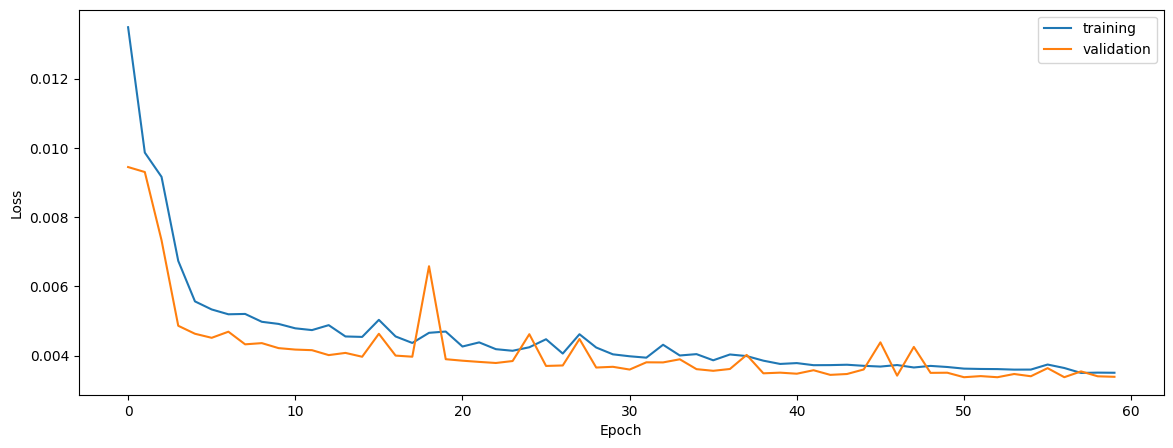

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8038188192791343
0.801139820385793
0.7691439784694072


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8038188192791343
0.801139820385793
0.7691439784694072


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.8071992491031145
0.8033840061411275
0.7799739797633894


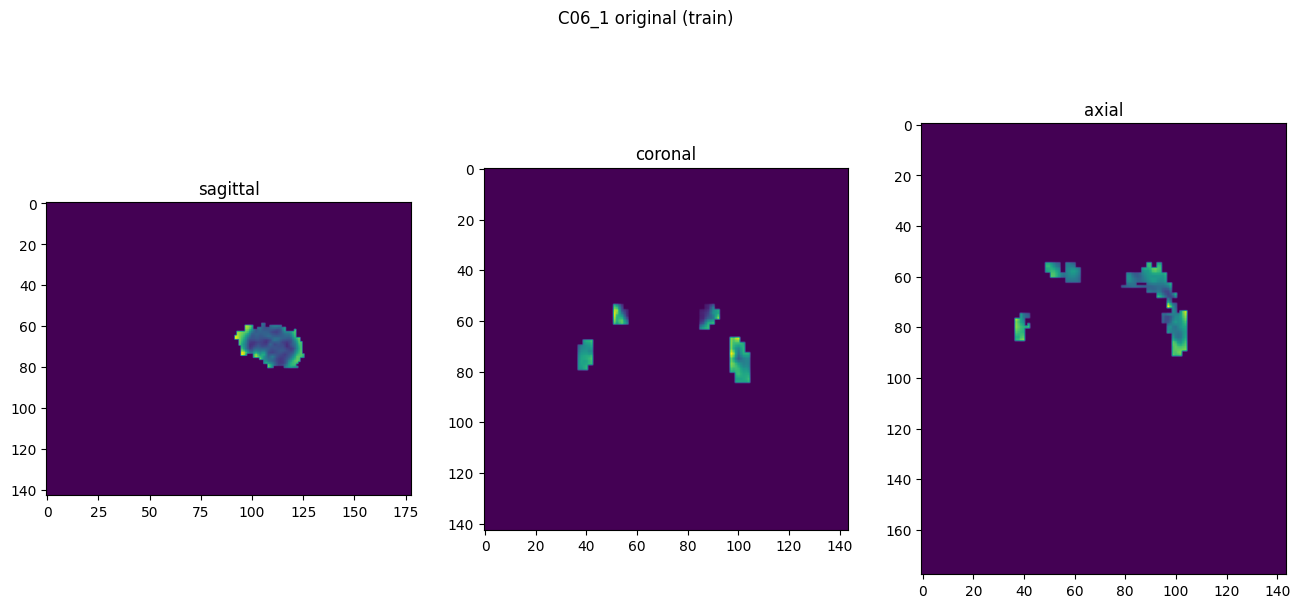

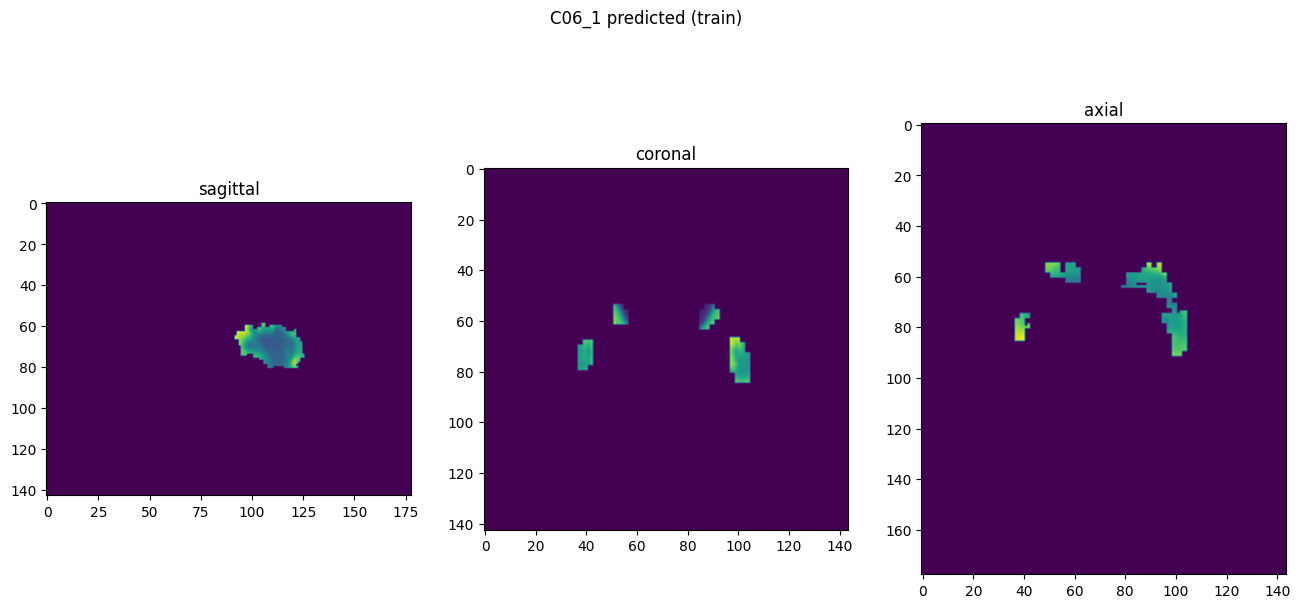

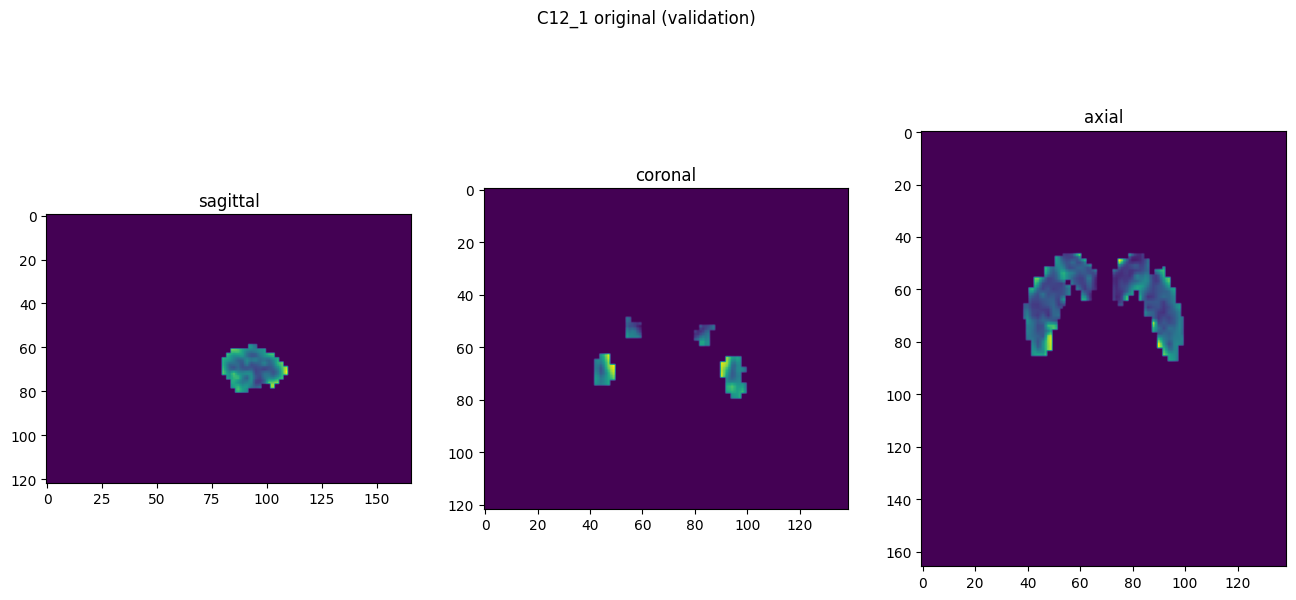

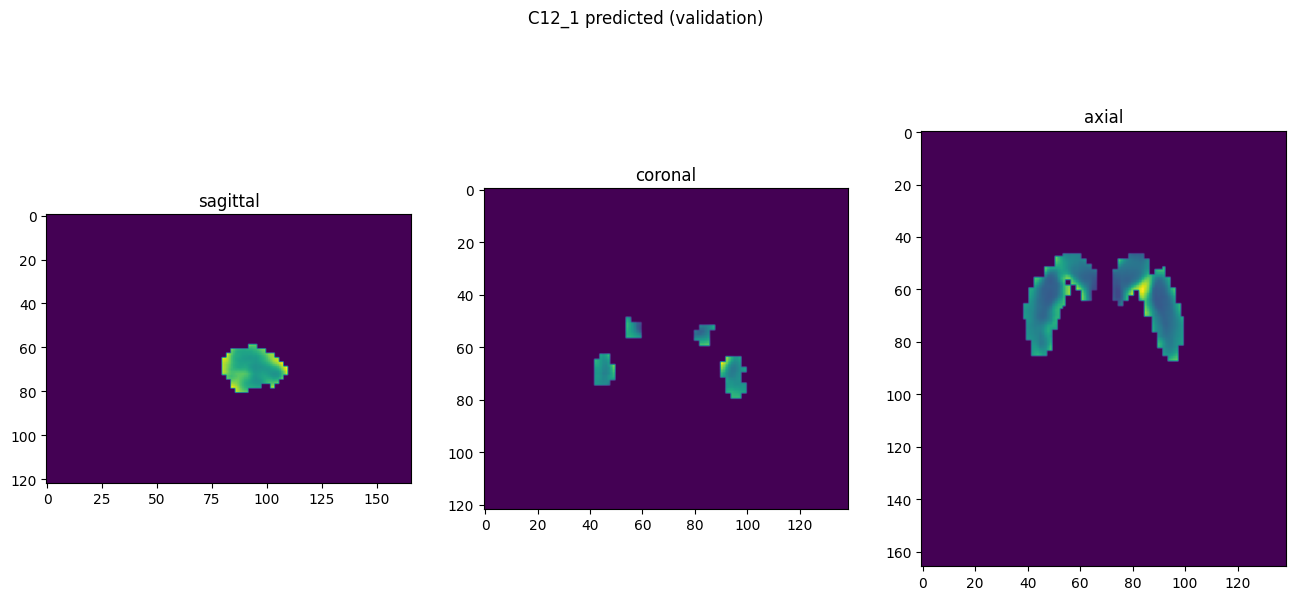

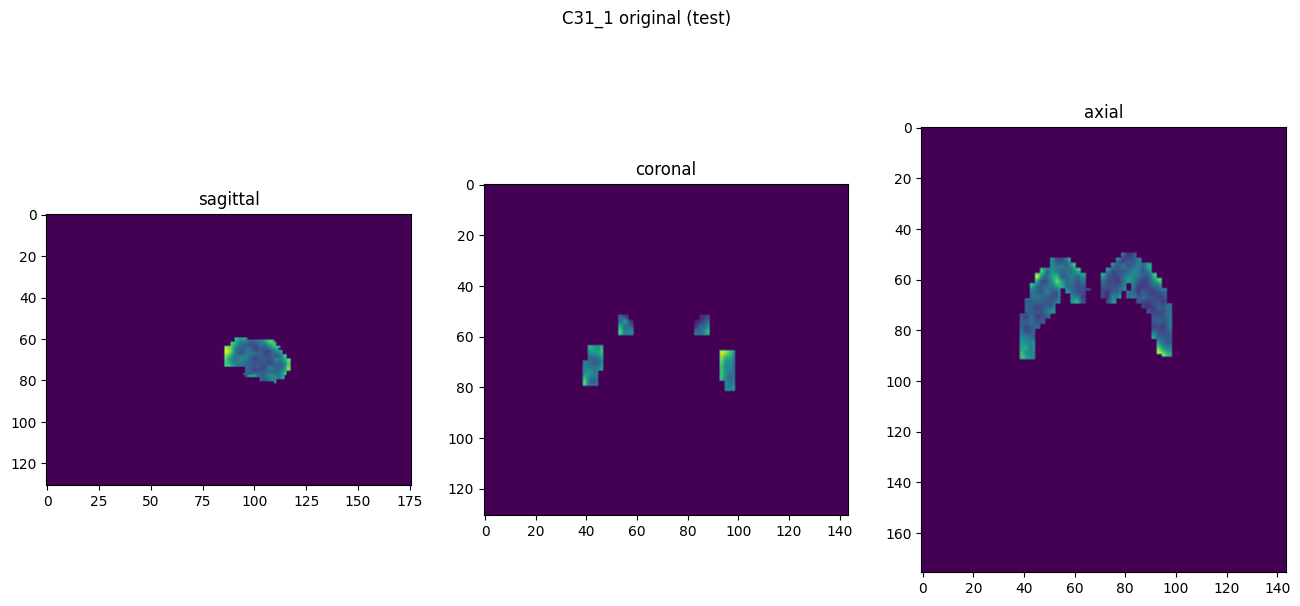

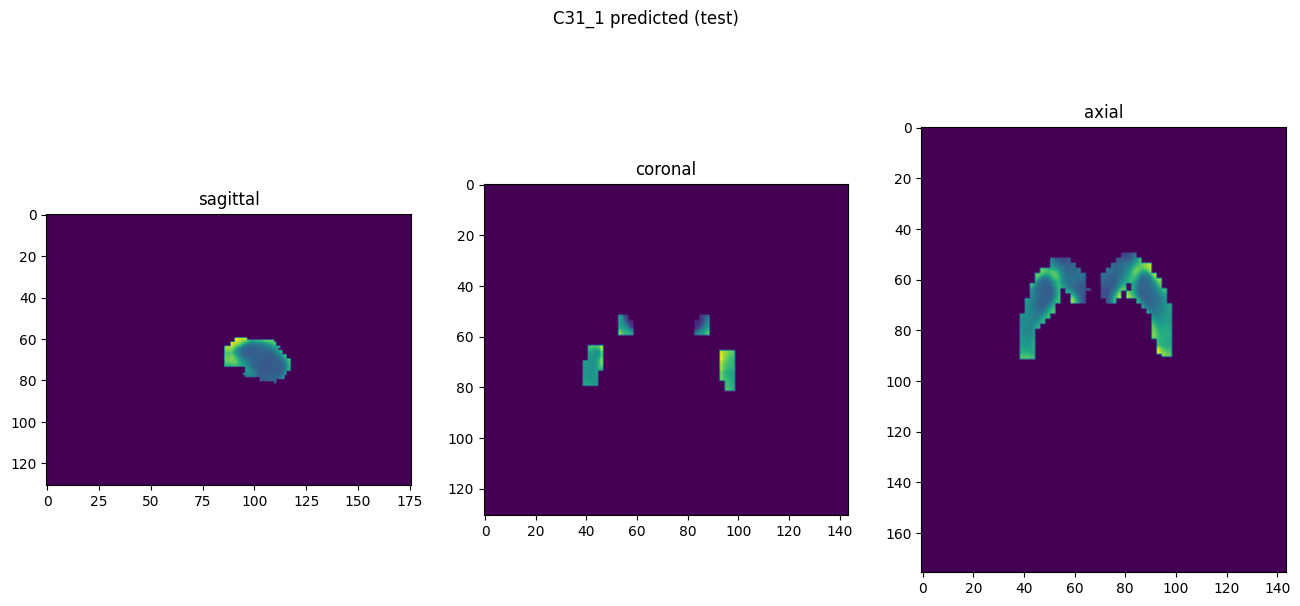

In [10]:
showResults(model, gen, threshold=None, background=False)